In [4]:
import matplotlib.pyplot as plt
import matplotlib

import numpy as np 
import os 
import PIL

import tensorflow as tf 
from tensorflow import keras        
from keras import layers 
from keras.models import Sequential

from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import adam_v2

import keras.applications
from keras.layers import Dense, GlobalAveragePooling2D,Flatten
from keras.models import Model

In [7]:
#Data Aug using Image Data Generator 

train= ImageDataGenerator(  validation_split=0.2,
                            shear_range = 0.2,
                            rotation_range=10,
                            brightness_range=[0.2,0.4],
                            zoom_range=[0.0,0.1])

validation = ImageDataGenerator(validation_split=0.2,
                                shear_range = 0.2,
                                rotation_range=10,
                                brightness_range=[0.2,0.4],
                                zoom_range=[0.0,0.1]
                                )

In [6]:
#train and validation Data Preparation 
train_dataset= train.flow_from_directory('CLAHE_applied',
                                         target_size=(450,300),  # need to spicify color at the end before(450,300)
                                         batch_size=7,
                                         subset="training",
                                         class_mode="categorical")

validation_dataset= validation.flow_from_directory("CLAHE_applied",
                                         target_size=(450,300),
                                         subset="validation",
                                         batch_size=7,
                                         class_mode="categorical")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'CLAHE_applied'

In [13]:
#list classes
class_names=train_dataset.class_indices
print(class_names)

{'4194': 0, '4201': 1, '4203': 2, '4211': 3, '4218': 4, '4220': 5}


In [18]:
resnet_model= tf.keras.Sequential()
pretrained_model=tf.keras.applications.ResNet50(
      include_top=False,
      weights="imagenet",
      input_tensor=None,
      input_shape=(450,300,3),
      pooling=None,
      classes=6
)
Model.save(pretrained_model,'Resnet_50.h5')

# Every layer inside that pretrained module is not Trainable unless True 
# Enable to Unlearn or Improve Accuracy  
for layer in pretrained_model.layers:
     layer.trainable=False

resnet_model.add(pretrained_model)
# Flatten the whole Resnet-50 layer to Single layer

resnet_model.add(Flatten())
resnet_model.add(Dense(512,activation='relu'))
resnet_model.add(Dense(6,activation='softmax')) 

In [23]:
pretrained_model= keras.models.load_model('Resnet_50.h5')
resnet_model= tf.keras.Sequential()

for layer in pretrained_model.layers:
     layer.trainable=False

resnet_model.add(pretrained_model)
# Flatten the whole Resnet-50 layer to Single layer

resnet_model.add(Flatten())
resnet_model.add(Dense(512,activation='relu'))
resnet_model.add(Dense(6,activation='softmax')) 

TypeError: __init__() got an unexpected keyword argument 'ragged'

In [18]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 15, 10, 2048)      23587712  
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [6]:
#optimizer Tuning
tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.998,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)

In [7]:
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [28]:
R50_model= resnet_model.fit(train_dataset,
                            #steps_per_epoch=10,
                            epochs=35, 
                            validation_data= validation_dataset)

Epoch 1/35
9/9 [==============================] - 40s 3s/step - loss: 212.8111 - sparse_categorical_accuracy: 0.2833 - val_loss: 89.4506 - val_sparse_categorical_accuracy: 0.3667
Epoch 2/35
9/9 [==============================] - 5s 566ms/step - loss: 83.2185 - sparse_categorical_accuracy: 0.2167 - val_loss: 63.2267 - val_sparse_categorical_accuracy: 0.3667
Epoch 3/35
9/9 [==============================] - 5s 564ms/step - loss: 56.2754 - sparse_categorical_accuracy: 0.4000 - val_loss: 61.7602 - val_sparse_categorical_accuracy: 0.3667
Epoch 4/35
9/9 [==============================] - 5s 572ms/step - loss: 44.9726 - sparse_categorical_accuracy: 0.4333 - val_loss: 32.9553 - val_sparse_categorical_accuracy: 0.5333
Epoch 5/35
9/9 [==============================] - 5s 560ms/step - loss: 15.2194 - sparse_categorical_accuracy: 0.5167 - val_loss: 18.9740 - val_sparse_categorical_accuracy: 0.4667
Epoch 6/35
9/9 [==============================] - 5s 571ms/step - loss: 16.3858 - sparse_categorical_

In [36]:
resnet_model.save('Res50weights.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [102]:
#list classes
class_names=train_dataset.class_indices
print(class_names)

{'4194': 0, '4201': 1, '4203': 2, '4211': 3, '4218': 4, '4220': 5}


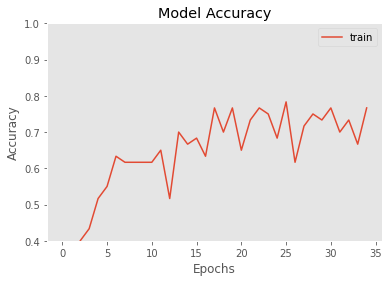

In [30]:
fig1 = plt.gcf()
plt.plot(R50_model.history['sparse_categorical_accuracy'])
plt.axis(ymin=.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'])
plt.show()

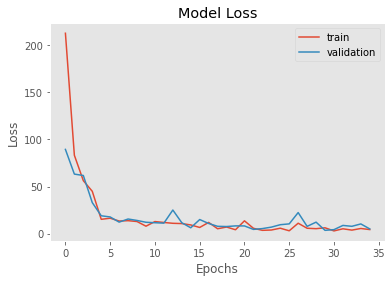

In [37]:
plt.plot(R50_model.history['loss'])
plt.plot(R50_model.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','validation'])
plt.show()

In [50]:
#Testing Path 
Results=[]
npval=[]
dir_path='/content/drive/MyDrive/dataset/CNN_dataset/test'
print(class_names,"\n") 

for i in os.listdir(dir_path):
  img= image.load_img(dir_path+'//'+i,target_size=(450,300))
  print(i)
  x= image.img_to_array(img)
  x=np.expand_dims(x,axis=0)
  #imgs=np.vstack([x])

  val= resnet_model.predict(x)
  npval.append(np.argmax(val))
  #op=class_names[npval]
print("\n Prediction Array \n",npval)  
  #output_class=class_names[np.argmax(val)]
  #print("The predicted class is", output_class)

{'4194': 0, '4201': 1, '4203': 2, '4211': 3, '4218': 4, '4220': 5} 

MatajiGaushala_Cow_Male_4194.png
MatajiGaushala_Cow_Female_11_4220.png
MatajiGaushala_Cow_Male_10_4218.png
MatajiGaushala_Cow_Male_4_4201.png

 Prediction Array 
 [3, 1, 1, 3]
